In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


In [2]:
mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

phase = 'wake'
subset = 'hdc'

bin_size = 160  # ms
single_spikes = False

delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

In [3]:
mouse_id = 'Mouse12'
session_id = 120806
phase = 'wake'
subset = 'nonhdc'

bin_size = 160  # ms
single_spikes = False

delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'


dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

basis_mode = 'ec'
C=3
model_dict = {
                'seed': 123, 
                'll_mode': f'U-{basis_mode}-{C}',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict['neurons'], 
                'max_count': dataset_dict['max_count'], 
                'bin_size': dataset_dict['bin_size'], 
                'tbin': dataset_dict['tbin'], 
                'model_name': dataset_dict['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-4, 
            }

hd_sweep = torch.linspace(0, 2*np.pi, 100)
angles = np.linspace(0, 360, hd_sweep.shape[-1])

modelfit, training_results, fit_set, validation_set = lib.models.load_model(
        checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
        delay, cv_run, batch_size, gpu_dev)

ll = lib.helper.RG_pred_ll(
                modelfit, fit_set, neuron_group=None, ll_mode='MC', 
                ll_samples=1, cov_samples=1, beta=0.0)
print(f'delay {delay}, LL = {ll}')



rcov = dataset_dict['covariates']
sweep = torch.linspace(0, 2*torch.pi, 100)[None, :]
rcov_matrix = [torch.tensor(rcov[k]) for k in rcov.keys()]
units_used = dataset_dict['neurons']

covariates=hd_sweep[None, None, :, None]
with torch.no_grad():
        P_mc = lib.helper.marginalized_P(
        modelfit, sweep, [list(rcov.keys()).index('hd')],
                                         rcov_matrix, batch_size, list(range(units_used)),
                                         MC=30, skip=3)  # predictive posterior
P_mc = P_mc.cpu()

units:  85  hdc units:  22
delay 0, LL = -187346.4575892857
99

In [4]:
K = P_mc.shape[-1]
counts = torch.arange(K)

hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2 
hd_FF = hd_var / (hd_mean + 1e-12)

[hd_rate] = utils.signal.percentiles_from_samples(hd_rate, [0.5])
[hd_FF] = utils.signal.percentiles_from_samples(hd_FF, [0.5])

# p(y=k | \theta) = P_mc[., ., theta, k]

# omit the constant part of SSI

prior = np.ones(P_mc.shape[2]) / P_mc.shape[2]
posterior = P_mc * prior[None, None, :, None]
norm_const = torch.sum(posterior, axis=2)
posterior = posterior / norm_const[:, :, None, :]
i_sp = np.log2(P_mc.shape[2]) + torch.sum(posterior * np.nan_to_num(torch.log2(posterior), neginf=0.0), axis=2)
SSI = torch.sum(P_mc * i_sp[:, :, None, :], axis=3)

[SSI] = utils.signal.percentiles_from_samples(SSI.float(), [0.5])

#[SSI] =  utils.signal.percentiles_from_samples(np.log2(P_mc.shape[2]) + torch.sum(P_mc * torch.sum(P_mc * torch.nan_to_num(torch.log2(P_mc), neginf=0.0), axis=2)[:,:,None,:], axis=-1), [0.5])

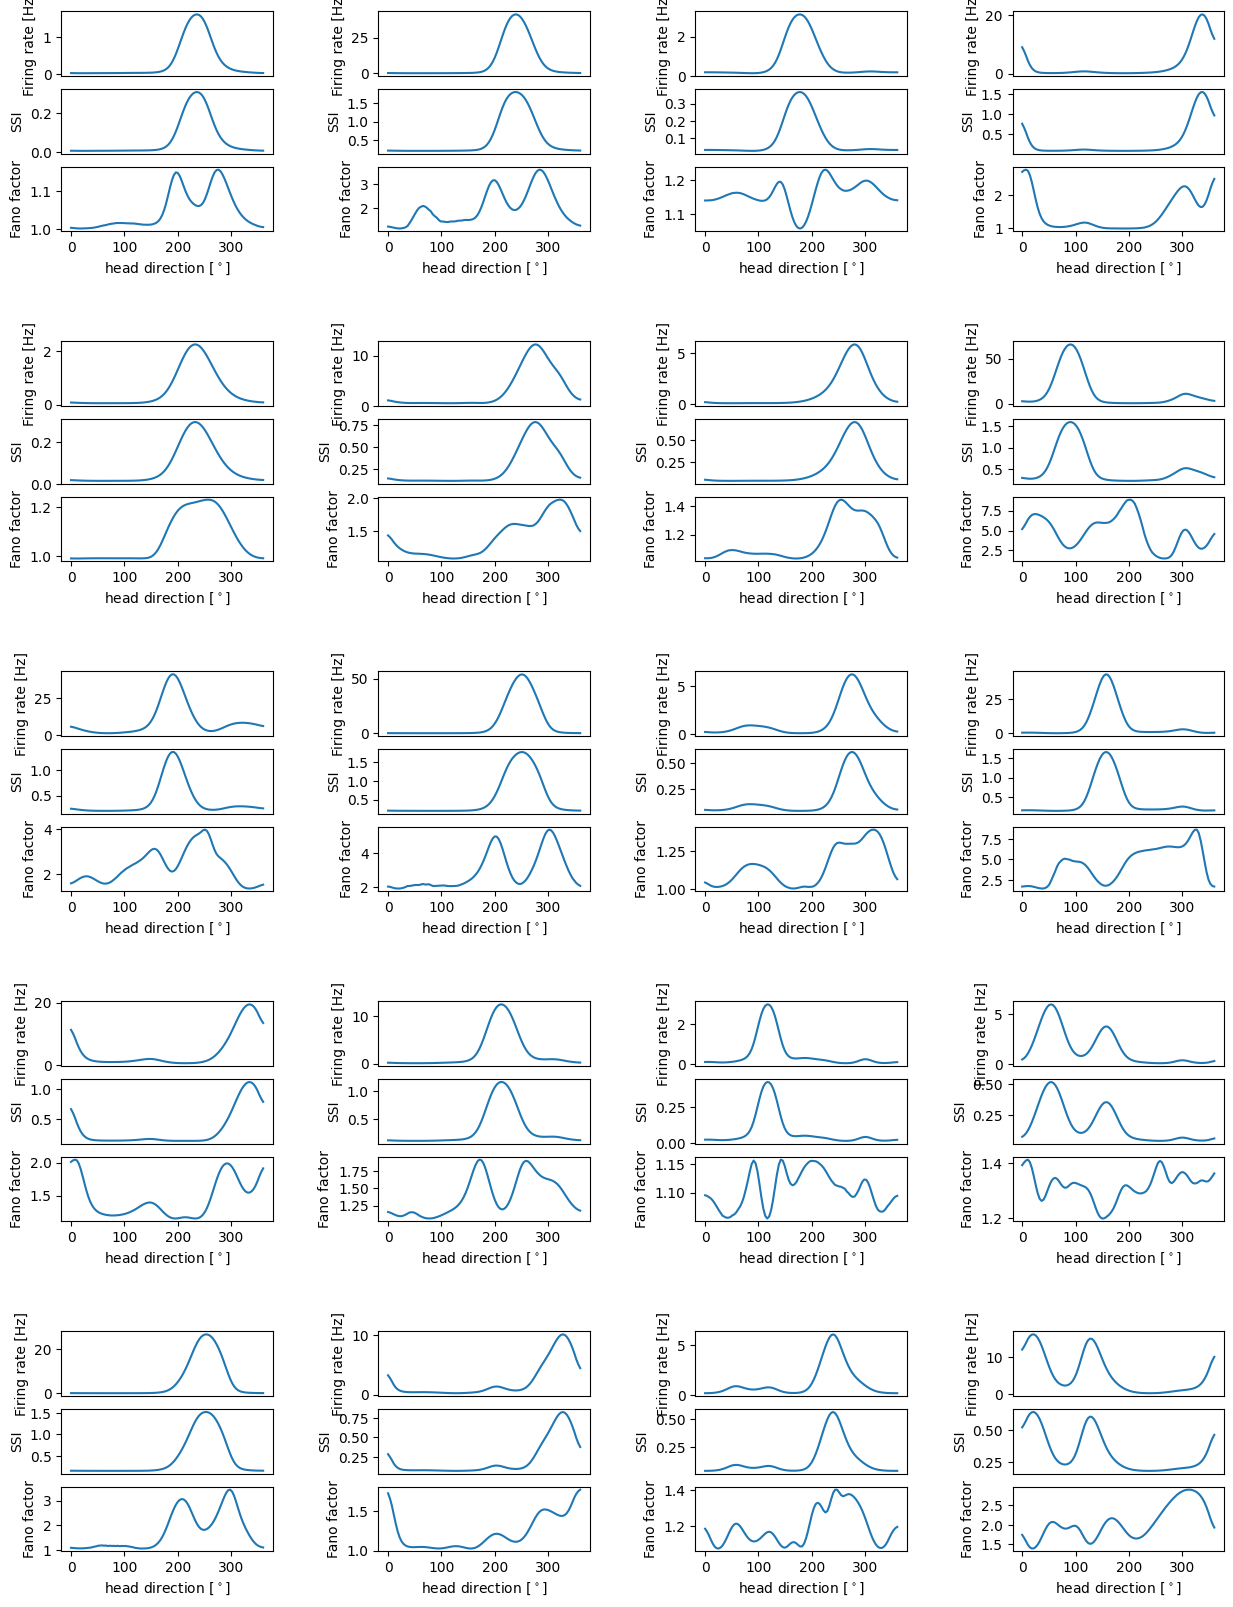

In [5]:
fig = plt.figure(figsize=(15,20))
spec = gridspec.GridSpec(5, 4, figure=fig, hspace=0.5, wspace=0.5)

for ne in np.arange(20):
    
    gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=spec[ne%5, ne//5])

    ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])]

    ax[0].plot(angles, hd_rate[ne])
    ax[1].plot(angles, SSI[ne])
    ax[2].plot(angles, hd_FF[ne])
    ax[0].set_ylabel('Firing rate [Hz]')
    ax[1].set_ylabel('SSI')
    ax[2].set_ylabel('Fano factor')
    ax[2].set_xlabel('head direction [$^\circ$]')

    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])


plt.tight_layout()

In [7]:
basis_mode = 'ec'
C=3
hd_sweep = torch.linspace(0, 2*np.pi, 100)
angles = np.linspace(0, 360, hd_sweep.shape[-1])

tc_rates = np.empty((0, 100))  # we have 6 covariates, so 6 features
SSIs = np.empty((0, 100))
tc_FFs = np.empty((0, 100))

label_hdc = np.empty((0,))

batch_size=600

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)
            model_dict = {
                            'seed': 123, 
                            'll_mode': f'U-{basis_mode}-{C}',  # stands for universal count model with exponential-quadratic expansion and C = 3
                            'filt_mode': '',  # GLM couplings
                            'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                            'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                            'z_mode': '',  # latent covariates
                            'hist_len': 0, 
                            'folds': 5, 
                            'delays': [0], 
                            'neurons': dataset_dict['neurons'], 
                            'max_count': dataset_dict['max_count'], 
                            'bin_size': dataset_dict['bin_size'], 
                            'tbin': dataset_dict['tbin'], 
                            'model_name': dataset_dict['name'], 
                            'tensor_type': torch.float, 
                            'jitter': 1e-4, 
                        }

            modelfit, training_results, fit_set, validation_set = lib.models.load_model(
                    checkpoint_dir, model_dict, dataset_dict, HDC.enc_used, 
                    delay, cv_run, batch_size, gpu_dev)

            rcov = dataset_dict['covariates']
            sweep = hd_sweep[None, :]
            rcov_matrix = [torch.tensor(rcov[k]) for k in rcov.keys()]
            units_used = dataset_dict['neurons']

            covariates=hd_sweep[None, None, :, None]
            with torch.no_grad():
                    P_mc = lib.helper.marginalized_P(
                    modelfit, sweep, [list(rcov.keys()).index('hd')],
                                                    rcov_matrix, batch_size, list(range(units_used)),
                                                    MC=30, skip=3)  # predictive posterior
            P_mc = P_mc.cpu()

            K = P_mc.shape[-1]
            counts = torch.arange(K)

            hd_mean = (counts[None, None, None, :] * P_mc).sum(-1)  # (MC, neurons, steps)
            hd_rate = hd_mean / dataset_dict['tbin']  # in units of Hz
            hd_var = (counts[None, None, None, :]**2 * P_mc).sum(-1) - hd_mean**2 
            hd_FF = hd_var / (hd_mean + 1e-12)

            [hd_rate] = utils.signal.percentiles_from_samples(hd_rate, [0.5])
            [hd_FF] = utils.signal.percentiles_from_samples(hd_FF, [0.5])

            # p(y=k | \theta) = P_mc[., ., theta, k]

            # omit the constant part of SSI

            prior = np.ones(P_mc.shape[2]) / P_mc.shape[2]
            posterior = P_mc * prior[None, None, :, None]
            norm_const = torch.sum(posterior, axis=2)
            posterior = posterior / norm_const[:, :, None, :]
            i_sp = np.log2(P_mc.shape[2]) + torch.sum(posterior * np.nan_to_num(torch.log2(posterior), neginf=0.0), axis=2)
            SSI = torch.sum(P_mc * i_sp[:, :, None, :], axis=3)

            [SSI] = utils.signal.percentiles_from_samples(SSI.float(), [0.5])

            tc_rates = np.concatenate((tc_rates, hd_rate), axis=0)
            tc_FFs = np.concatenate((tc_FFs, hd_FF), axis=0)
            SSIs = np.concatenate((SSIs, SSI), axis=0)

            if subset == 'hdc':
                label_hdc = np.concatenate((label_hdc, np.ones(dataset_dict['neurons'])))
            else:
                label_hdc = np.concatenate((label_hdc, np.zeros(dataset_dict['neurons'])))


units:  85  hdc units:  22
99units:  85  hdc units:  22
99units:  21  hdc units:  2
99units:  21  hdc units:  2
99units:  46  hdc units:  7
99units:  46  hdc units:  7
99units:  50  hdc units:  7
99units:  50  hdc units:  7
99units:  55  hdc units:  5
99units:  55  hdc units:  5
99units:  59  hdc units:  7
99units:  59  hdc units:  7
99units:  11  hdc units:  2
99units:  11  hdc units:  2
99units:  13  hdc units:  4
99units:  13  hdc units:  4
99units:  17  hdc units:  4
99units:  17  hdc units:  4
99units:  22  hdc units:  6
99units:  22  hdc units:  6
99units:  28  hdc units:  5
99units:  28  hdc units:  5
99units:  40  hdc units:  11
99units:  40  hdc units:  11
99units:  43  hdc units:  11
99units:  43  hdc units:  11
99units:  36  hdc units:  10
99units:  36  hdc units:  10
99units:  32  hdc units:  5
99units:  32  hdc units:  5
99units:  33  hdc units:  11
99units:  33  hdc units:  11
99units:  56  hdc units:  14
99units:  56  hdc units:  14
99

In [8]:
SSIs.shape

(647, 100)

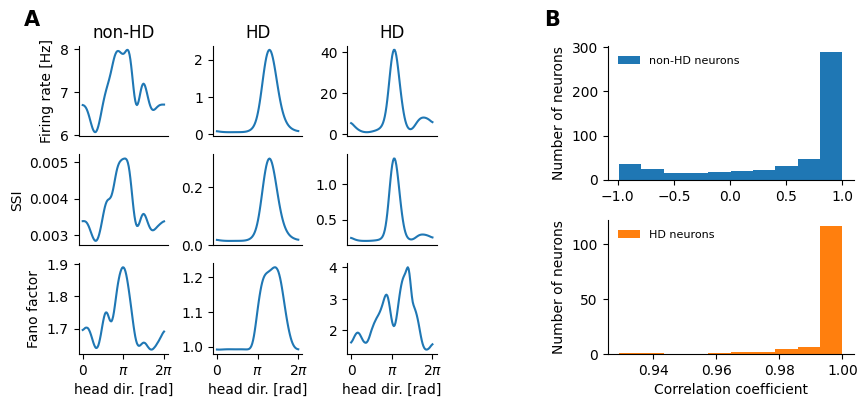

In [68]:
fig = plt.figure(figsize=(10, 4))

fig.text(0.07, 0.93, 'A', transform=fig.transFigure, size=15, fontweight='bold')
fig.text(0.59, 0.93, 'B', transform=fig.transFigure, size=15, fontweight='bold')


gs00 = gridspec.GridSpec(1,2, fig, wspace=0.1, width_ratios=[2,1])

correlations = np.empty((0,))

for ne in range(SSIs.shape[0]):
    C = np.corrcoef(SSIs[ne], tc_rates[ne])
    correlations = np.append(correlations, C[0,1])


gs0 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs00[1], hspace=0.3)

legendsize=10

ax = fig.add_subplot(gs0[0])
ax.hist(correlations[np.invert(label_hdc.astype(bool))], label='non-HD neurons')
#ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('Number of neurons')
ax.spines[['top', 'right']].set_visible(False)
ax.legend(prop={'size': 8}, frameon=False)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


ax = fig.add_subplot(gs0[1])
ax.hist(correlations[label_hdc.astype(bool)], color = colors[1], label='HD neurons')
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('Number of neurons')
ax.legend(prop={'size': 8}, frameon=False)
ax.spines[['top', 'right']].set_visible(False)

gs1 = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=gs00[0], wspace=0.5)

for i, ne in enumerate([28, 1, 2]):
    
    gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs1[i])

    ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])]

    if i == 0:
        ax[0].set_title('non-HD')
    else:
        ax[0].set_title('HD')

    ax[0].plot(angles, tc_rates[ne])
    ax[1].plot(angles, SSIs[ne])
    ax[2].plot(angles, tc_FFs[ne])
    if i == 0:
        ax[0].set_ylabel('Firing rate [Hz]')
        ax[1].set_ylabel('SSI')
        ax[2].set_ylabel('Fano factor')
    ax[2].set_xlabel('head dir. [rad]')
    ax[2].set_xticks([0, 180, 360])
    ax[2].set_xticklabels(['0', '$\pi$', '$2\pi$'])


    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])

    for j in range(3):
        ax[j].spines[['top', 'right']].set_visible(False)
fig.tight_layout()

fig.savefig("/homes/vn283/UCM-interpret/figures/ssi_correlations.pdf", format="pdf", bbox_inches="tight")


18


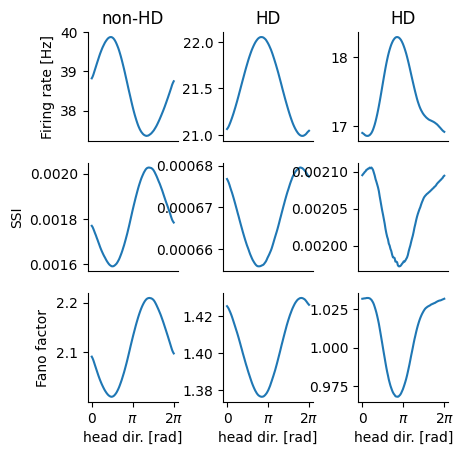

In [59]:
a = np.where(correlations < -0.9)
a = np.array(a)

print(a.size)

fig = plt.figure()

gs1 = gridspec.GridSpec(1,4, fig, wspace=0.5)

for i, ne in enumerate([a[0,0], a[0,1], a[0,2]]):
    
    gs = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs1[i])

    ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2])]

    if i == 0:
        ax[0].set_title('non-HD')
    else:
        ax[0].set_title('HD')

    ax[0].plot(angles, tc_rates[ne])
    ax[1].plot(angles, SSIs[ne])
    ax[2].plot(angles, tc_FFs[ne])
    if i == 0:
        ax[0].set_ylabel('Firing rate [Hz]')
        ax[1].set_ylabel('SSI')
        ax[2].set_ylabel('Fano factor')
    ax[2].set_xlabel('head dir. [rad]')
    ax[2].set_xticks([0, 180, 360])
    ax[2].set_xticklabels(['0', '$\pi$', '$2\pi$'])


    ax[0].set_xticklabels([])
    ax[0].set_xticks([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])

    for j in range(3):
        ax[j].spines[['top', 'right']].set_visible(False)
fig.tight_layout()

# Synthetic distributions

In [63]:
from scipy.stats import norm 

In [64]:
r_max = 10
s_preffered = np.pi
sigma_preffered = 1
T=1

def rate(s): 
    return r_max * np.exp(-0.5 * (s - s_preffered)**2 / sigma_preffered**2) + 1

inputs = np.linspace(0, 2*np.pi, 100)
dtheta = inputs[1] - inputs[0]

r_avg = np.mean(rate(inputs))

def norm_constant(l, s, nu):
    const = 0
    for k in range(100):
        const += (l**k) / ((np.math.factorial(k))**nu)
    return const

def cm_poisson(r, s, nu=1): 
    """ Conway-Maxwell Poisson"""
    l = rate(s)/(rate(s)+1)
    norm_const = norm_constant(l, s, nu)
    return 1 / norm_const * (l**r) / ((np.math.factorial(r))**nu)

def manual_scd(r, s, sigma=0.1, left = np.pi/2, right = 3*np.pi/2):
    if s > left and s < right:
        #return 2 * rate(s) / (K*(K+1))
        if r < 2*rate(s)+1:
            return 1 / (2*rate(s)+1)
        else:
            return 0
    m = rate(s)
    p = norm.cdf(r+1, loc=m, scale=sigma) - norm.cdf(r, loc=m, scale=sigma)
    return p

def manual_scd_2(r, s, sigma=0.1, left = 2*np.pi/3, right = 4*np.pi/3):
    if s < s_preffered:
        if r < 2*rate(s)+1:
            return 1 / (2*rate(s)+1)
        else:
            return 0
    m = rate(s)
    p = norm.cdf(r+1, loc=m, scale=sigma) - norm.cdf(r, loc=m, scale=sigma)
    return p

def geometric(r, s):
    p = 1 / (rate(s)+1)
    return p*(1-p)**r 

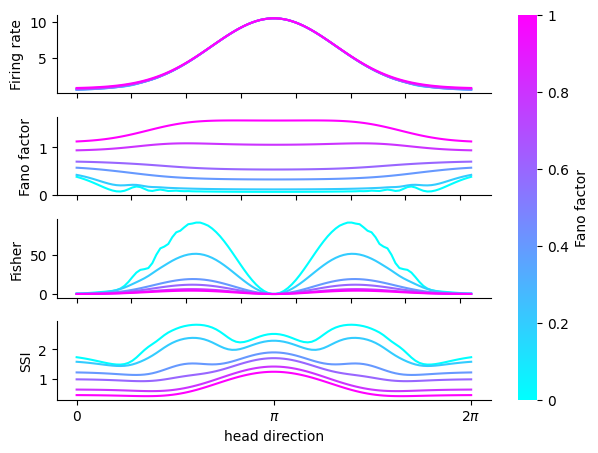

In [67]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(7,5))

gs = gridspec.GridSpec(4, 1, fig, hspace=0.3)

ax = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3])]

K = 150
rs = np.arange(0, K)
probs = np.empty((inputs.size, rs.size))
angles = inputs * 180 / (np.pi)

colors = plt.cm.cool(np.linspace(0, 1, 6))

for i, FF in enumerate([0.05, 0.1, 0.3, 0.5, 1, 1.5]):
    probs = np.empty((inputs.size, rs.size))

    for i1, r in enumerate(rs):
        for j1, s in enumerate(inputs):
            #probs[j, i] = cm_poisson(r, s, nu=1)
            #probs[j, i] = geometric(r, s)
            sigma = np.sqrt(FF * rate(s))
            probs[j1, i1] = manual_scd(r, s, sigma=sigma, left=0, right=0)
            #probs[j, i] = manual_scd_2(r, s, sigma=1)

    mean = (rs[None, :] * probs).sum(-1)
    var = (rs[None, :]**2 * probs).sum(-1) - mean**2
    FF = var/mean

    fisher_poisson = T*(np.gradient(mean) / dtheta)**2 / mean
    grad = np.gradient(np.nan_to_num(np.log(probs), neginf=0.0), axis=0) / dtheta
    fisher = (grad**2 * probs).sum(-1)

    prior = np.ones(inputs.shape) / inputs.shape
    posterior = probs * prior[:, None]
    norm_const = np.sum(posterior, axis=0)
    posterior = np.nan_to_num(posterior / norm_const[None, :], nan=0.0)

    i_sp = np.log2(inputs.size) + np.sum(posterior * np.nan_to_num(np.log2(posterior), neginf=0.0), axis=0)
    SSI = np.sum(probs * i_sp[None, :], axis=1)


    #fisher[np.where(fisher > 3000)] = np.nan
    #ax[0].set_title('Poisson distribution')
    ax[0].plot(angles, mean, color=colors[i])
    ax[0].set_ylabel('Firing rate')
    ax[1].plot(angles, FF, color=colors[i])
    ax[1].set_ylabel('Fano factor')
    ax[2].plot(angles, fisher, color=colors[i])
    ax[2].set_ylabel('Fisher')
    ax[3].plot(angles, SSI, color=colors[i])
    ax[3].set_ylabel('SSI')

    for i in range(3):
        ax[i].set_xticklabels([])
    
    ax[3].set_xticks([0, 180, 360])
    ax[3].set_xticklabels(['0', '$\pi$', '$2\pi$'])
    ax[3].set_xlabel('head direction')

    for i in range(4):
        ax[i].spines[['top', 'right']].set_visible(False)

sm = plt.cm.ScalarMappable(cmap=plt.cm.cool)
cbar = fig.colorbar(sm, ax=ax[:], )
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])  # vertically oriented colorbar
cbar.ax.set_ylabel('Fano factor')
cbar.outline.set_visible(False)

fig.savefig("/homes/vn283/UCM-interpret/figures/ssi_validation.pdf", format="pdf", bbox_inches="tight")

In [ ]:
import scipy.stats

Text(0.5, 0, 'head direction')

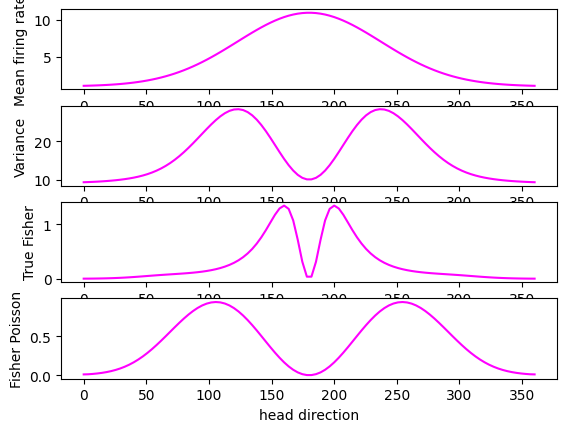

In [ ]:
dt = 0.16

r_max = 10

def mean_SCD(s, s_preffered = np.pi, sigma=1): 
    return (r_max * np.exp(-0.5 * (s - s_preffered)**2 / sigma**2) + 1)*dt


def variance(s, s_preffered = np.pi, sigma=1):
    return 50*(np.exp(-0.5 * (s - s_preffered)**2 / sigma**2) * (- (s-s_preffered)/ sigma**2) )**2 + 10


def nbinom_SCD(y, s):
    p = mean_SCD(s)/variance(s)
    n = mean_SCD(s)**2 / (variance(s) - mean_SCD(s))
    return scipy.stats.nbinom.pmf(y, n, p)

K = 250
rs = np.arange(0, K)
probs = np.empty((inputs.size, rs.size))
angles = inputs * 180 / (np.pi)

probs = np.empty((inputs.size, rs.size))

for i1, r in enumerate(rs):
    for j1, s in enumerate(inputs):
        probs[j1, i1] = nbinom_SCD(r, s)

mean = (rs[None, :] * probs).sum(-1)
var = (rs[None, :]**2 * probs).sum(-1) - mean**2
FF = var/mean

fisher_poisson = T*(np.gradient(mean) / dtheta)**2 / mean
grad = np.gradient(np.nan_to_num(np.log(probs), neginf=0.0), axis=0) / dtheta
fisher = (grad**2 * probs).sum(-1)

prior = np.ones(inputs.shape) / inputs.shape
posterior = probs * prior[:, None]
norm_const = np.sum(posterior, axis=0)
posterior = np.nan_to_num(posterior / norm_const[None, :], nan=0.0)

i_sp = np.log2(inputs.size) + np.sum(posterior * np.nan_to_num(np.log2(posterior), neginf=0.0), axis=0)
SSI = np.sum(probs * i_sp[None, :], axis=1)

fig, ax = plt.subplots(4, 1)
#fisher[np.where(fisher > 3000)] = np.nan
#ax[0].set_title('Poisson distribution')
ax[0].plot(angles, mean/dt, color=colors[i])
ax[0].set_ylabel('Mean firing rate')
ax[1].plot(angles, FF*mean, color=colors[i])
ax[1].set_ylabel('Variance')
ax[2].plot(angles, fisher, color=colors[i])
ax[2].set_ylabel('True Fisher')
ax[3].plot(angles, fisher_poisson, color=colors[i])
ax[3].set_ylabel('Fisher Poisson')
ax[3].set_xlabel('head direction')

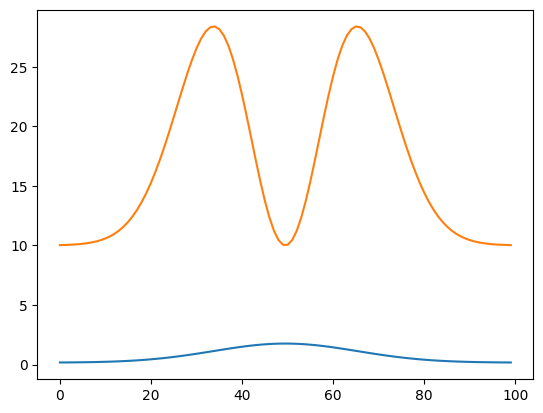

In [ ]:
m = []
v = []

for s in inputs:
    m.append(mean_SCD(s))
    v.append(variance(s))

plt.plot(m)
plt.plot(v)